# FINAL PRACTICE

## F105 Analysis

Import all the necessary component

In [107]:
import numpy as np
import sep

In [108]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = [10., 8.]

Get the data from the fits file, read and show it in its original form

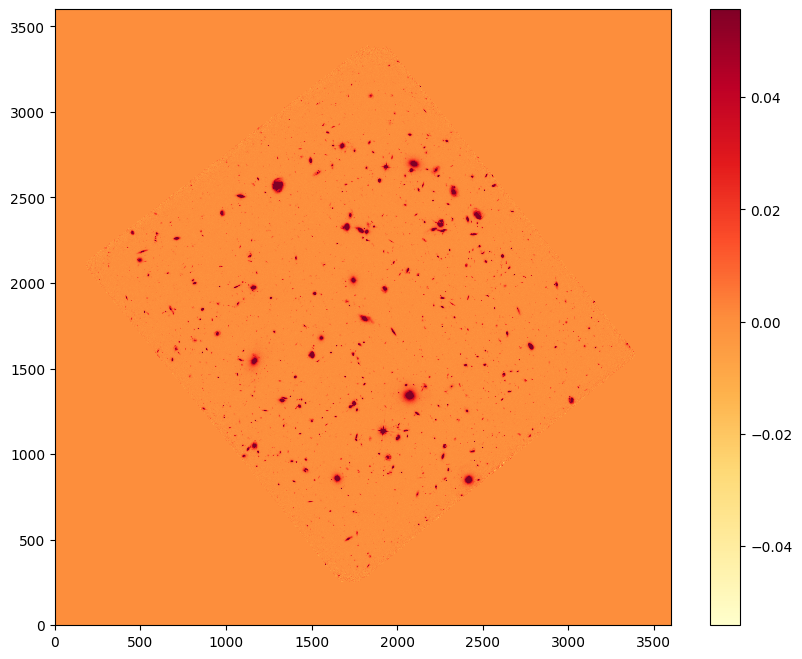

In [109]:
# open FITS file with astropy instead of fitsio
image = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
hdu = fits.open(image)
data_image = hdu[0].data

new_data = data_image.astype(data_image.dtype.newbyteorder("="))
new_data = data_image.byteswap()
new_data = new_data.view(new_data.dtype.newbyteorder("="))
data_image = data_image.byteswap()
data_image = data_image.view(data_image.dtype.newbyteorder("="))

m, s = np.mean(data_image), np.std(data_image)
plt.imshow(data_image, interpolation='nearest', cmap='YlOrRd', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("F105_original.png") # save the figure as png

### Background subtraction

Removing background for source detection

In [110]:
bkg = sep.Background(data_image) # returns a Background object that holds information on the spatially varying background and spatially varying background noise level.

In [111]:
print(bkg.globalback) # background value
print(bkg.globalrms) # noise value

0.0
0.0005398219218477607


#### Background

In [112]:
bkg_image = bkg.back() # evaluate background as 2-d array, same size as original image

show the background

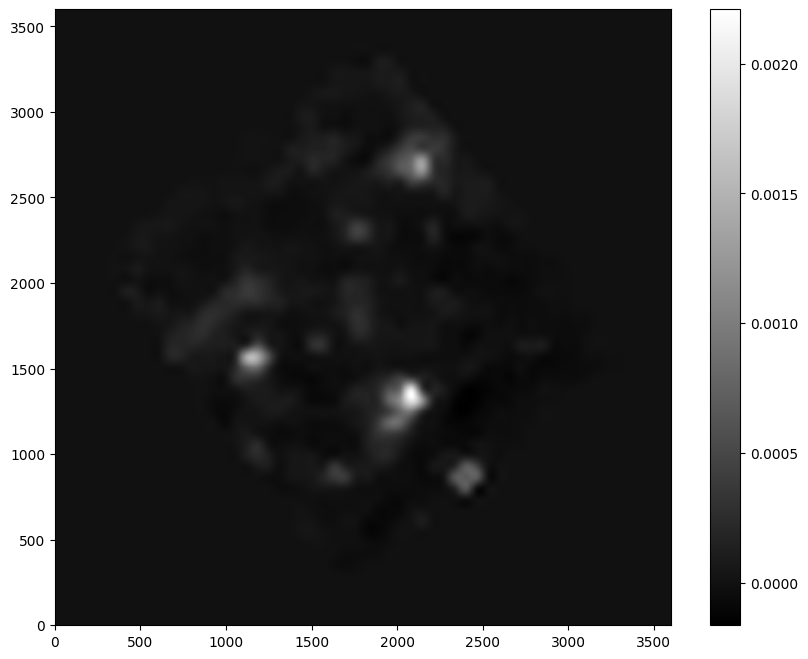

In [113]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("F105_background.png") # save the figure as png

#### Noise

In [114]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

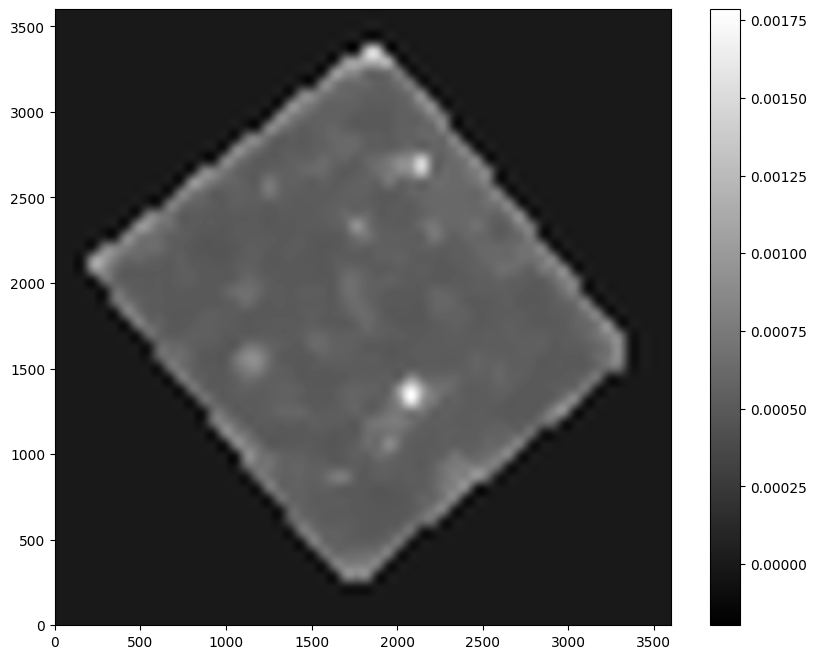

In [115]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("F105_noise.png") # save the figure as png

In [116]:
# subtract the background
data_sub = data_image - bkg_image

### Object detection

In [117]:
objects = sep.extract(data_sub, 4.5, err=bkg.globalrms) # threshold adjusted accordingly

In [118]:
# how many objects were detected
print(f"There are {len(objects)} objects found in the image")

There are 2889 objects found in the image


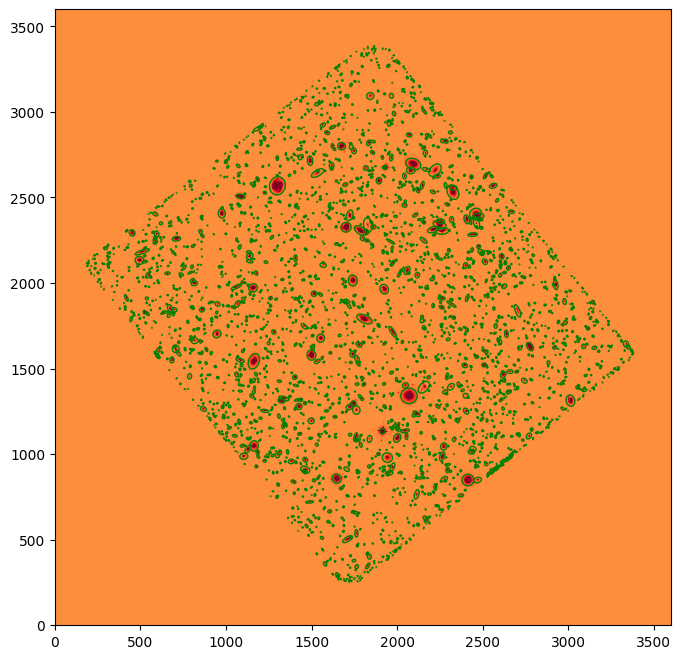

In [119]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='YlOrRd',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('green')
    ax.add_artist(e)

fig.savefig("F105_object_detection.png") # save the figure as png

In [120]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

### Aperture photometry

In [121]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [122]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.035727 +/- 0.189038
object 1: flux = 0.081285 +/- 0.285120
object 2: flux = 0.064035 +/- 0.253068
object 3: flux = 0.070403 +/- 0.265351
object 4: flux = 0.038717 +/- 0.196788
object 5: flux = 0.104682 +/- 0.323559
object 6: flux = 0.043227 +/- 0.207932
object 7: flux = 0.061414 +/- 0.247835
object 8: flux = 0.019772 +/- 0.140644
object 9: flux = 0.025214 +/- 0.158814


### Fluxes analysis

Histogram of the fluxes (the amount of light coming from the detected object)

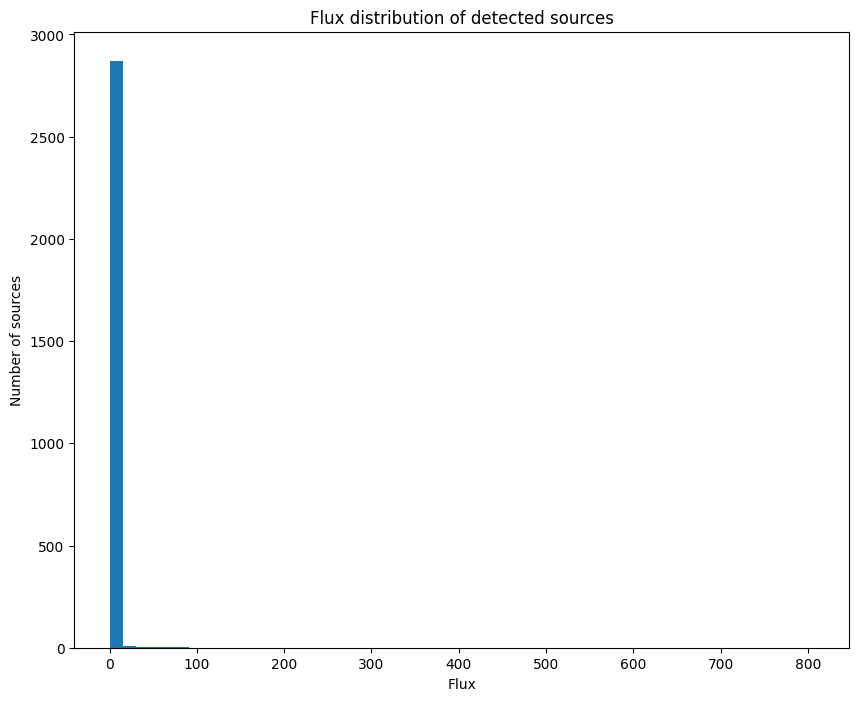

We can see most sources are low in brightness


<Figure size 1000x800 with 0 Axes>

In [123]:
plt.figure()
n_bins = int(np.sqrt(len(flux))) # learned from the group project
plt.hist(flux, bins=n_bins)
plt.xlabel("Flux")
plt.ylabel("Number of sources")
plt.title("Flux distribution of detected sources")
plt.show()

plt.savefig("F105_flux_histogram.png") # save the figure as png

print("We can see most sources are low in brightness")

Find the mean, median, and standard deviation of the distribution of fluxes

In [124]:
flux_mean = np.mean(flux)
flux_median = np.median(flux)
flux_std = np.std(flux)

print(f"Mean of flux: {flux_mean}")
print(f"Median of flux: {flux_median}")
print(f"Standard deviation of flux: {flux_std}")

Mean of flux: 1.0467906209632707
Median of flux: 0.13273207535967238
Standard deviation of flux: 15.965674390266132


Find the largest outlier and its position

In [125]:
z_scores = (flux - flux_mean) / flux_std # z-score

max_flux = flux[np.argmax(z_scores)]
max_z = z_scores[np.argmax(z_scores)]

x_max = objects['x'][np.argmax(z_scores)]
y_max = objects['y'][np.argmax(z_scores)]

print("Largest outlier flux:", max_flux)
print("Its position (x, y):", x_max, y_max)
print("Standard deviations from the mean:", max_z)

Largest outlier flux: 807.2972835731507
Its position (x, y): 1914.2511650217743 1134.319980541274
Standard deviations from the mean: 50.498993856704104


Show on the graph

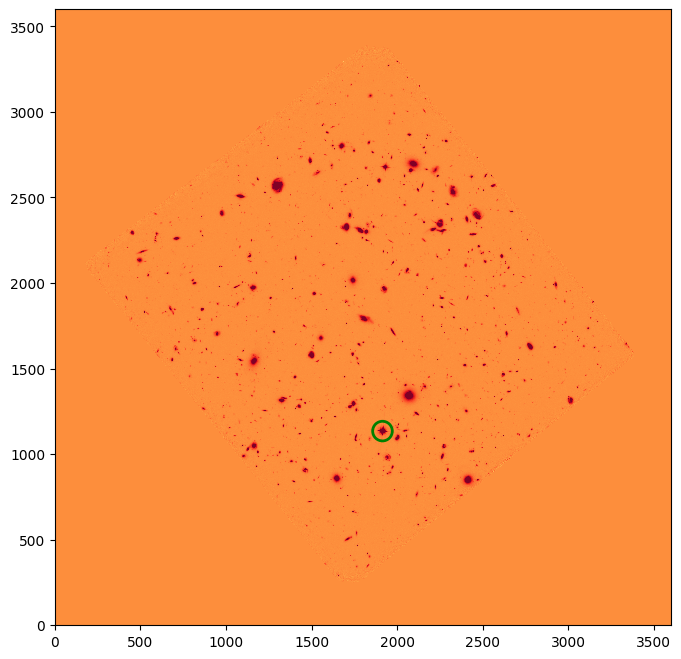

In [126]:
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
ax.imshow(data_sub, interpolation='nearest', cmap='YlOrRd',
          vmin=m-s, vmax=m+s, origin='lower')

ax.scatter([x_max], [y_max], s=200, edgecolor='green',linewidths= 2, facecolor='none')
plt.show()

fig.savefig("F105_largest_outlier_location.png")

## FALSE COLOR CONVERSION

### Set up

In [127]:
image_f105 = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
image_f125 = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
image_f160 = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

Write the function that deal with SEP's error when using astropy to read fits files, so it could be reused without repetitive coding

In [128]:
def read_fits(filename):
    hdu = fits.open(filename)
    data_image = hdu[0].data

    new_data = data_image.astype(data_image.dtype.newbyteorder("="))
    new_data = data_image.byteswap()
    new_data = new_data.view(new_data.dtype.newbyteorder("="))
    data_image = data_image.byteswap()
    data_image = data_image.view(data_image.dtype.newbyteorder("="))

    return data_image

### Print each image as it is, making sure none of them have any issue

In [129]:
img105 = read_fits(image_f105) # blue
img125 = read_fits(image_f125) # green
img160 = read_fits(image_f160) # red

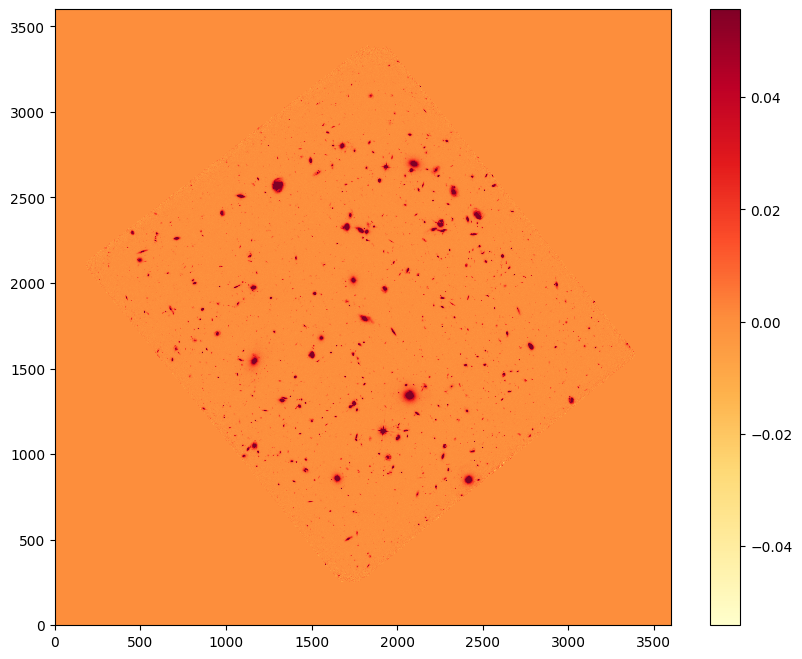

In [130]:
m, s = np.mean(data_image), np.std(data_image)
plt.imshow(img105, interpolation='nearest', cmap='YlOrRd', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("img105.png") # save the figure as png

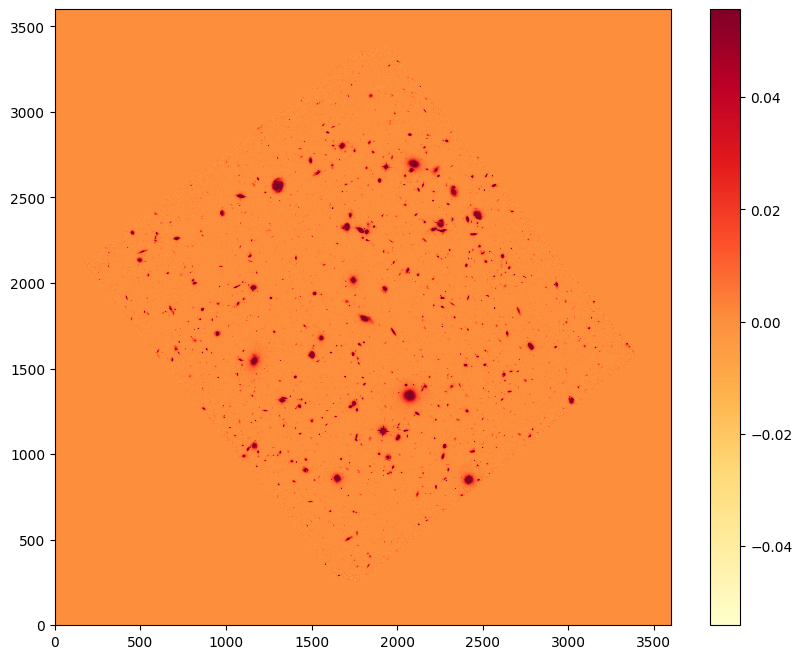

In [131]:
m, s = np.mean(data_image), np.std(data_image)
plt.imshow(img125, interpolation='nearest', cmap='YlOrRd', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("img125.png") # save the figure as png

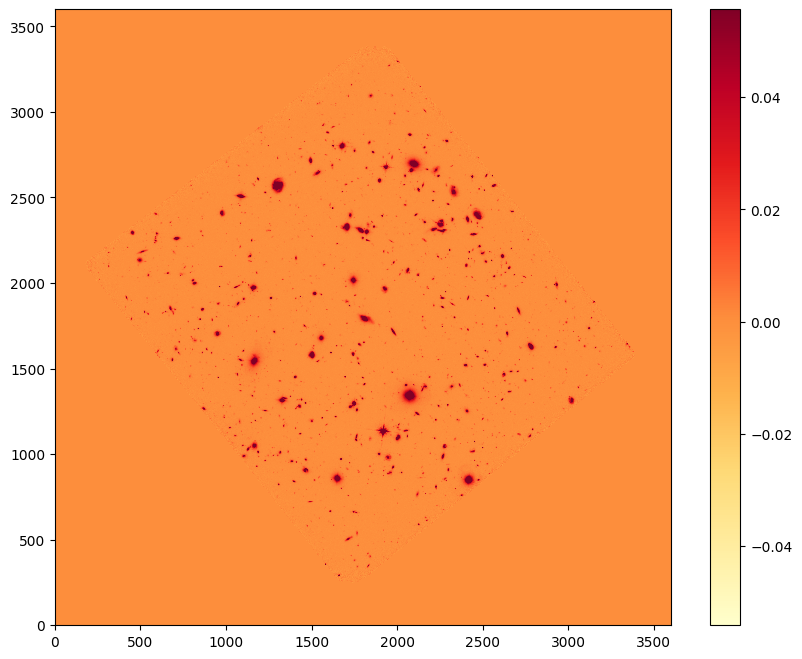

In [132]:
m, s = np.mean(data_image), np.std(data_image)
plt.imshow(img160, interpolation='nearest', cmap='YlOrRd', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("img160.png") # save the figure as png

### False colormap

make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w

In [133]:
from astropy.visualization import make_lupton_rgb

In [134]:
red = img160
green = img125
blue = img105

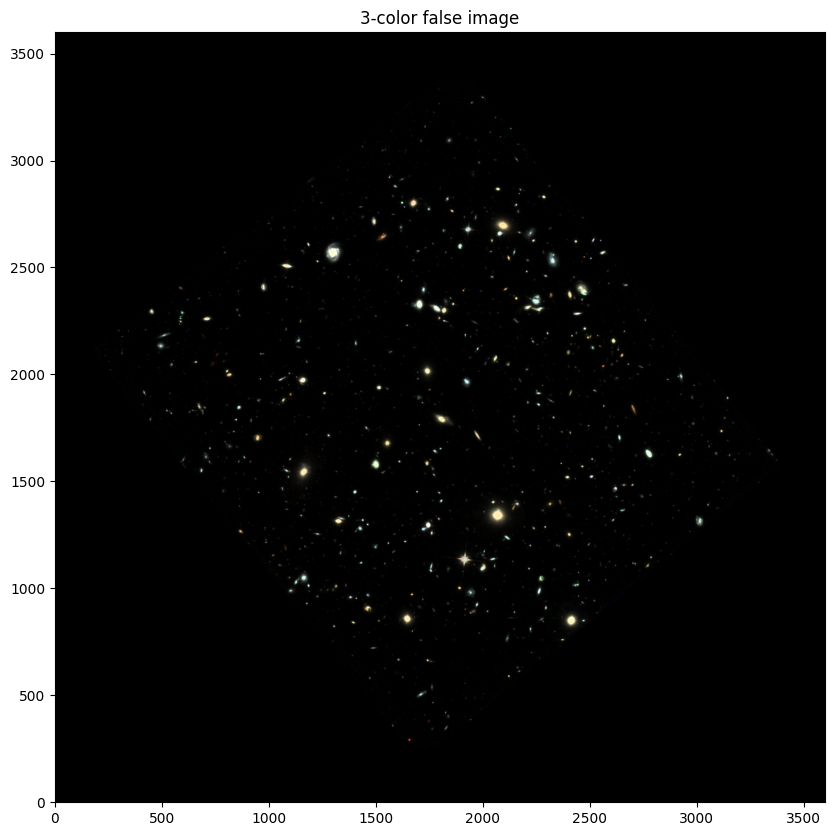

In [141]:
rgb = make_lupton_rgb(red, green, blue, Q=0, stretch=0.1)
plt.figure(figsize=(10, 10),facecolor='none')
plt.imshow(rgb, origin='lower')
plt.title("3-color false image")
plt.savefig("3-color false image.png")
plt.show()